# Project Report

This is the report for the Train a Smartcab How to Drive project of Udacity's Nanodegree program in Machine Learning. The project consists of using reinforcement learning techniques in the form of a simple game in which the objective is to ensure that the smartcab can be trained with data from the environment, following its strict rules of traffic to reach its destination in the shortest possible time, and with the lower numbers of errors. All graphical representations are next to the project code [repository](https://github.com/drschilling/smartcab).


### Performance metrics and rules

We know that the objective of the project is to find the ideal conditions within the problem of automating a smart cab how to drive alone for this we must take into account some metrics that will ensure if the agent had good or poor performance during the course of its training. Good performance means reaching the destination within a small time interval and not miss the traffic rules as follows. 

###### Traffic rules


* **Green traffic light:**
Can do: Move
 / Can't do: left turn when  oncoming traffic is going forward or turning right 

* **Red traffic light:**
Can do: right turn when no oncoming traffic from the left going forward
 / Can't do: Move


Next I detail each of the metrics I used to evaluate three different stages of agent building (random actions, with Q Learning implemented and Q Learning optimized):

* **time_left** : We calculate the sum of the remaining time so that the agent reaches the limit of time that he has available to reach his final destination. We can then say that agents that have a lower calculated sum reach their destiny more quickly, and therefore are more performative.


* **total_penalties**: The total penalties are calculated to reveal whether the agent is following the traffic rules in the environment. Agents that accumulate large sums of penalty are indicative of taking more random actions and not having a good performance. 


* **destination_reached** : We basically indicate with ``True`` or ``False`` whether or not the agent has reached the programmed destination.

 ##### Exclusive for Q-Learning:
 

* **alpha**: the learning rate its a value set between 0 and 1. If we set it to 0 it means that the Q-values are never updated, hence nothing is learned. Setting a high value such as 0.9 means that learning can occur quickly.


* **epsilon**: The probability of an event should occur.


### Random Agent

First, we implement an agent with a set of random actions ** ['forward', 'left', 'right', None]** within the four types of actions that an agent can take, where our smartcab can go forward, can turn right, turn left or take no action at all. Its implementation in the agent code ([random_agent](https://github.com/drschilling/smartcab/blob/master/smartcab/random_agent)) was as follows:

In [ ]:
 self.actions = ['forward', 'left', 'right', None]  # set of possible actions
 
 def update(self, t):
        # Gather inputs
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        
        act = random.choice(self.actions) # random choice of actions

 ***An agent with random set of actions will therefore not follow any of the traffic rules present in the environment, which will make it very error-prone and with a very low performance.***

The agent with random actions has its performance measured from the [results](https://github.com/drschilling/smartcab/blob/master/smartcab/results/random_output.csv) of the metrics generated after one hundred trials:

![Image title](smartcab/results/random_table_results.png)

As we have noted above, the agent has a very poor performance with only 66% of destinations reached, and with an extremely high penalty rate with an average of 47 points per attempt. The high penalty rate is directly linked to the agent's random actions where the agent does not obey the traffic rules and has no impediment to making mistakes. The relation between destinations reached and the frequency of penalties can be observed on **Plot 1** where we observe clearly the inversely proportional relation between the penalty values and the success or not of each attempt.  


#### Plot 1
![Image title](smartcab/results/penaltiesxdestination_random.png)


Another indication that the agent is negatively affected by not updating the required pieces of information of its state is the low value for the time left for the agent to reach its destination as we can see according to the **Plot 2** when the high values for the time left  concurs with positive cases destination reached, something that can be justified by the agent extrapolating frequently the deadline before reaches its destiny.


#### Plot 2
![Image title](smartcab/results/timeleftxdestination_random.png)


From the results observed in the two plots above we can arrive at two conclusions:

* High penalty values are inversely proportional to the agent's success rates in reaching its destination.

* High values of time left indicate that the agent has reached its goal before the deadline, which indicates success.

Based on the observations above, when we look at  the **Plot 3** that makes a relation between penalties and time left we can clearly observe that the two have an **inversely** proportional relation, that is, an agent who suffers from a higher level of penalties will not reach its goal within a small period of time.


#### Plot 3
![Image title](smartcab/results/timeleftxpenalties_random.png)

### Updating the state

The agent must move within a grid space (eight columns and six rows) wherein each attempt a destination represented by a coordinate (x, y) will be assigned to it. This destination should be reached within a delta time considering the enviroment traffic rules, and if the deadline is reached it is considered that the agent failed to reach the final destination.With each new attempt to reach the destination, our agent's current state is updated by receiving a new traffic **light** rule, a new **oncoming** traffic actions, information about if there is traffic from the **right** of the agent, information about if there is traffic from the **left** of the agent, a **new waypoint position** to which it must be moved to reach the destination, and a **deadline** which will measure the amount of time that agent has to reach its destination. 

For this project I will not consider updating the information for **left** and **right** because I believe that these could be used in more specific situations, and the same can be obtained by updating the oncoming and lights parameters. I also will not consider **deadline** because it has a dynamic nature and decreases every time an agent moves. What means that even if my agent have encountered that particular inputs['light'], inputs['oncoming'], self.next_waypoint instance before, it would consider it a different state if the deadline is different not guaranteeing a consistency. Each of these new input data that updates the state of our agent can be explained as:


* Light: The agent will follow severe traffic rules depending on the state of the traffic lights which directly influence the degree of success of the agent, since obeying the traffic rules from the lights['red' or 'green'] diminishes the chance of the agent suffering unnecessary penalties.


* Oncoming: Depending on the oncoming traffic the agent will take a different action regarding the state of the traffic lights as we mentioned above.The possible oncoming actions will be (None, 'left', 'right', 'forward').


* Next waypoint: The action that points the direction where the agent should move towards reaching its destination. It's the most important information to be updated if we want to guarantee that agent will have success. The possible set of values for the next waypoint is ('left', 'right','forward'). 
      

In [ ]:
def update(self, t):
        # Gather inputs
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        self.state = (inputs['light'], inputs['oncoming'], self.next_waypoint)  # create a primary state

We represent above in code how the state will be updated from the information of lights, oncoming and next waypoint.

### Implementing Q-Learning

The Q-Learning algorithm agent tries to learn an optimal policy from its interactions from a specific environment. The consequence of the agent-environment is a sequence of state-action rewards: **[state0,action0,reward1,state1,action1,reward2...]**.

The agent first in state **state0** performs an action **action0**, resulting in the reward **reward1** and this tuple **(state,action,reward,state')**, state, and action, with a consequential reward generates the formation of a new state for the agent, **state1**; that performs an action action1, receiving the reward reward2, and so on. Treating every interaction **(state, action) -> reward** as a experience. The rewards will have different natures according to the performance of the agent with direct consequence of its actions. We will then rate the types of reward in:


| Reward type         | Description                                                                                                               |
|---------------------|---------------------------------------------------------------------------------------------------------------------------|
| Positive            | Every time the agent reaches its destination or reaches successfully the next waypoint within the predetermined deadline. |
| Neutral             | When the agent successfully obeys the traffic rules and stands still.                                                     |
| Negative = Penalty | Every time the agent makes an incorrect move or, not follow the traffic rules or causes an accident.       


Each one of the experiences will guard the information that the agent needs no learn how to act next and learn the best policy.As in decision-theoretic planning, the aim is for the agent to maximize its Q value from its previous action, which is usually the discounted reward:


#### _Q[state,action] ← (1-alpha) Q[state,action] + alpha(reward+ γmaxaction' Q[state',action'])_ 

Each experience (state,action,reward,state') provides a data point for the value of **Q[state,action]** called return, where Q[state,action] represents the expected value (cumulative discounted reward) when the agent follows the optimal policy. The agent can use the temporal difference equation to update its estimate for the Q(state,action).From the **q_learning** function, we have in the code the implementation of the above equation for the agent learning process from the previous action and the reward:


In [ ]:
def q_learning(self, act, alpha, reward_from_action, next_state):
    self.q_table[self.state][self.actions.index(act)] = (1 - alpha) * self.q_table[self.state][
        self.actions.index(act)] + (alpha * (reward_from_action + max(self.q_table[next_state])))

### Q-Learning Agent

Based on what we discussed above, an agent is implemented in the code that undergoes learning from Q-learning, and its implementation in the agent code ([q_learning_agent](https://github.com/drschilling/smartcab/blob/master/smartcab/q_learning_agent)) was as follows:

In [ ]:
def update(self, t):
        # Gather inputs
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        self.state = (inputs['light'], inputs['oncoming'], self.next_waypoint)  # create a primary state

        # Updating the current state
        max_q_value = self.q_table[self.state].index(max(self.q_table[self.state]))

        # Selecting an action Epsilon greedy policy that is selecting random actions with uniform distribution
        # from a set of available actions.
        self.epsilon = 1.0 / self.num_trials
        if random.random() < self.epsilon:
            act = random.choice(self.env.valid_actions) # selecting a random action
        else:
            act = self.actions[max_q_value] # selecting a max action

        reward_from_action = self.env.act(self, act) # from the action above we will have a reward

        # if the reward is received as a penalty we count that
        if reward_from_action < 0:
            self.n_penalties += 1

        location = self.env.agent_states[self]["location"]
        destination = self.env.agent_states[self]["destination"]

        # if the agent reaches its destination we save that information
        if location == destination:
            self.destination_reached = True

        self.alpha = 1.0 / self.num_trials # learning rate decay
        next_inputs = self.env.sense(self) # a new set of inputs
        new_waypoints = self.planner.next_waypoint() # a new set of waypoints

        # from the policy we generate a new state from the next set of inputs
        next_state = (next_inputs['light'], next_inputs['oncoming'], new_waypoints)

        # get maximum Q value for this next state based on all possible actions and learning rate
        self.q_learning(act, self.alpha, reward_from_action, next_state)

**An agent with a not random set of actions will, therefore, try to follow the traffic rules present in the environment as much as possible, behavior that will eventually improve the agent performance.** Its performance is measured from the [results](https://github.com/drschilling/smartcab/blob/master/smartcab/results/q_learning_output.csv) of the metrics generated by one hundred trials:

![Image title](smartcab/results/q_learning_results.png)

According to the results the agent has a high performance with 99% of destinations reached, and with a low penalty rate with an average of ~4 points per attempt. 

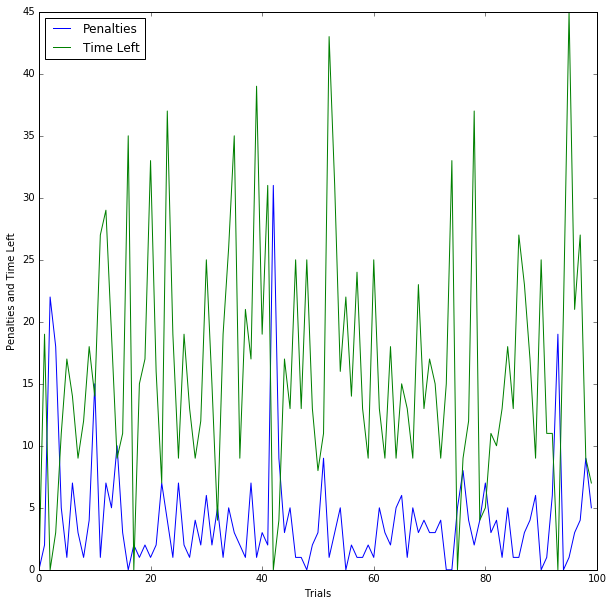

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))

#import pandas as pd
#df = pd.read_csv('smartcab/results/q_learning_output.csv')
#features = df.drop('number_of_trials', axis = 1)
#features.describe()

#df_random = pd.read_csv('smartcab/results/random_output.csv')
df_qlearning = pd.read_csv('smartcab/results/q_learning_output.csv')
#df_optimized = pd.read_csv('smartcab/results/optimized_output.csv' )

#penalties_random = df_random.time_left.tolist()
penalties_qlearning = df_qlearning.number_of_penalties.tolist()
time_left_qlearning = df_qlearning.time_left.tolist()
#time_left = df_random.time_left.tolist()
#destination_reached = df_random.destination_reached.tolist()

plt.plot(range(0,100), penalties_qlearning, label='Penalties', color='b')
plt.plot(range(0,100), time_left_qlearning, label='Time Left', color='g')
#plt.plot(range(0,100), optimized_penalties, label='Optimized')

plt.xlabel('Trials')
plt.ylabel('Penalties and Time Left')
plt.legend(loc=2)

plt.show()

# Implement a Q-Learning Driving Agent
With your driving agent being capable of interpreting the input information and having a mapping of environmental states, your next task is to implement the Q-Learning algorithm for your driving agent to choose the best action at each time step, based on the Q-values for the current state and action. Each action taken by the smartcab will produce a reward which depends on the state of the environment. The Q-Learning driving agent will need to consider these rewards when updating the Q-values. Once implemented, set the simulation deadline enforcement enforce_deadline to True. Run the simulation and observe how the smartcab moves about the environment in each trial.

**QUESTION**: _What changes do you notice in the agent's behavior when compared to the basic driving agent when random actions were always taken? Why is this behavior occurring?_

**Answer:**

# Improve the Q-Learning Driving Agent
Your final task for this project is to enhance your driving agent so that, after sufficient training, the smartcab is able to reach the destination within the allotted time safely and efficiently. Parameters in the Q-Learning algorithm, such as the learning rate (alpha), the discount factor (gamma) and the exploration rate (epsilon) all contribute to the driving agent’s ability to learn the best action for each state. To improve on the success of your smartcab:

* Set the number of trials, n_trials, in the simulation to 100.
* Run the simulation with the deadline enforcement enforce_deadline set to True (you will need to reduce the update delay update_delay and set the display to False).
* Observe the driving agent’s learning and smartcab’s success rate, particularly during the later trials.
* Adjust one or several of the above parameters and iterate this process.

This task is complete once you have arrived at what you determine is the best combination of parameters required for your driving agent to learn successfully.

**QUESTION**: _Report the different values for the parameters tuned in your basic implementation of Q-Learning. For which set of parameters does the agent perform best? How well does the final driving agent perform?_

**QUESTION**: _Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties? How would you describe an optimal policy for this problem?_

**Answer:**